BEST ETFs for hedging factors (from 2019-01-01): 

Market: QQQ  

Size: VBR  

Value: IWN  

Profitability: DGRW  

Investment: QMOM 

[*********************100%***********************]  1 of 1 completed
C:\Users\MukeshwaranBaskaran\AppData\Local\Temp\ipykernel_38560\913616620.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  benchmark_returns = benchmark_prices.resample('M').last().pct_change().dropna()


              Metric  Original Portfolio  Market-Neutral Portfolio  \
0       Total Return            6.348625                  5.185716   
1  Annualized Return            0.453495                  0.407297   
2       Sharpe Ratio            2.708578                  2.824029   
3      Sortino Ratio            5.820972                  7.751862   
4       Max Drawdown           -0.082888                 -0.069828   

   FF5-Neutral Portfolio  
0               4.907965  
1               0.395226  
2               2.815295  
3               9.119262  
4              -0.057163  


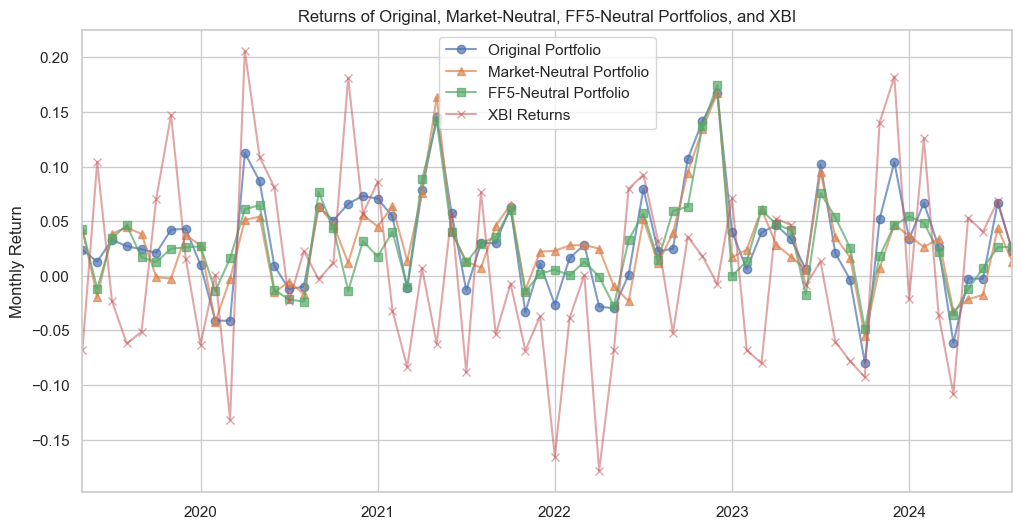


Factor Exposures (Betas):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.932
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           0.000790
Time:                        11:42:40   Log-Likelihood:                 114.86
No. Observations:                  64   AIC:                            -217.7
Df Residuals:                      58   BIC:                            -204.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0289    

In [122]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
import getFamaFrenchFactors as gff

# Load portfolio data
def load_portfolio_data(file_path):
    df = pd.read_excel(file_path)
    df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Returns'] = df['P&L (%)'].fillna(0)
    relevant_columns = ['AUM BOD', 'AUM EOD', 'P&L (%)', 'Returns']
    return df[relevant_columns]

# Load portfolio data
file_path = r"C:\Users\MukeshwaranBaskaran\Downloads\Project_KISKI\Data\KISKI_Portfolio_Monthly.xlsx"
portfolio_data = load_portfolio_data(file_path)

# Get returns from the portfolio data
r_a = portfolio_data['Returns']

# Set dynamic start and end dates based on portfolio data
start_date = portfolio_data.index.min()
end_date = "2024-08-31"  # Update this as needed

# Get benchmark (XBI) data within the dynamic date range
benchmark_symbol = "XBI"
benchmark_prices = yf.download(benchmark_symbol, start=start_date, end=end_date)['Close']

# Calculate benchmark returns (monthly)
benchmark_returns = benchmark_prices.resample('M').last().pct_change().dropna()

# Load Fama-French 5 Factor data
ff5_monthly = gff.famaFrench5Factor(frequency='m')
ff5_monthly['date_ff_factors'] = pd.to_datetime(ff5_monthly['date_ff_factors'])
ff5_monthly.set_index('date_ff_factors', inplace=True)

# Ensure all data is aligned
returns_df = pd.DataFrame({
    'Portfolio': r_a,
    'Benchmark': benchmark_returns,
    'Mkt-RF': ff5_monthly['Mkt-RF'],
    'SMB': ff5_monthly['SMB'],
    'HML': ff5_monthly['HML'],
    'RMW': ff5_monthly['RMW'],
    'CMA': ff5_monthly['CMA'],
    'RF': ff5_monthly['RF']
})
returns_df = returns_df.dropna()

# Extract aligned data
r_a = returns_df['Portfolio']
r_b = returns_df['Benchmark']
ff_factors = returns_df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
rf = returns_df['RF']

# Calculate alpha and beta for market-neutral portfolio
X_market = sm.add_constant(r_b)
model_market = sm.OLS(r_a - rf, X_market).fit()
alpha_market, beta_market = model_market.params

# Construct a market-neutral portfolio
portfolio_market_neutral = r_a - rf - beta_market * (r_b - rf)
portfolio_market_neutral.name = "Market-Neutral Portfolio"

# Calculate alpha and betas for Fama-French 5-factor model
X_ff5 = sm.add_constant(ff_factors)
model_ff5 = sm.OLS(r_a - rf, X_ff5).fit()
alpha_ff5, *betas_ff5 = model_ff5.params

# Construct a Fama-French 5-factor neutral portfolio
portfolio_ff5_neutral = r_a - rf - (betas_ff5[0] * ff_factors['Mkt-RF'] + 
                                    betas_ff5[1] * ff_factors['SMB'] + 
                                    betas_ff5[2] * ff_factors['HML'] + 
                                    betas_ff5[3] * ff_factors['RMW'] + 
                                    betas_ff5[4] * ff_factors['CMA'])
portfolio_ff5_neutral.name = "FF5-Neutral Portfolio"

# Define function to calculate performance metrics
def calculate_performance_metrics(returns):
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 12
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    annualized_volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility
    downside_returns = returns[returns < 0]
    downside_volatility = downside_returns.std() * np.sqrt(12)
    sortino_ratio = annualized_return / downside_volatility if downside_volatility != 0 else np.nan
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return total_return, annualized_return, sharpe_ratio, sortino_ratio, max_drawdown

# Calculate performance metrics for all portfolios
metrics_original = calculate_performance_metrics(r_a)
metrics_market_neutral = calculate_performance_metrics(portfolio_market_neutral)
metrics_ff5_neutral = calculate_performance_metrics(portfolio_ff5_neutral)

# Create a DataFrame for the comparison
metrics_df = pd.DataFrame({
    'Metric': ['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown'],
    'Original Portfolio': metrics_original,
    'Market-Neutral Portfolio': metrics_market_neutral,
    'FF5-Neutral Portfolio': metrics_ff5_neutral
})

# Display the comparison
print(metrics_df)

# Plot returns
plt.figure(figsize=(12, 6))
r_a.plot(label='Original Portfolio', alpha=0.7, marker='o')
portfolio_market_neutral.plot(label='Market-Neutral Portfolio', alpha=0.7, marker='^')
portfolio_ff5_neutral.plot(label='FF5-Neutral Portfolio', alpha=0.7, marker='s')
r_b.plot(label='XBI Returns', alpha=0.5, marker='x')
plt.ylabel("Monthly Return")
plt.legend()
plt.title("Returns of Original, Market-Neutral, FF5-Neutral Portfolios, and XBI")
plt.show()

# Calculate and print factor exposures
print("\nFactor Exposures (Betas):")
print(model_ff5.summary())

# Calculate the R-squared for the FF5 model
r_squared_ff5 = model_ff5.rsquared
print(f"\nR-squared for FF5 model: {r_squared_ff5:.4f}")

# Calculate the portion of risk explained by the FF5 factors
risk_explained = r_squared_ff5 * 100
print(f"Percentage of risk explained by FF5 factors: {risk_explained:.2f}%")
print(f"Percentage of risk unexplained (idiosyncratic): {100 - risk_explained:.2f}%")